# **Baseline GRU with just MSE**


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a Optuna hyperparameters optimisation and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.

## **IMPORTANT NOTE**: 
- do preprocessing from ``preprocess.ipynb`` to obtain data in ``data/data_combined``, before starting this notebook
- make sure the notebook is under ``src`` directory before running!
- change the global variables defined below for the desired years of data, loss function and NN type



In [20]:
8.43756260858009 ** 2

71.19246277370884

In [2]:
# check if all results rmse are sqrt of mse
import pandas as pd
import numpy as np
import glob
import os

from pathlib import Path
BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src

RESULTS_PATH = BASE_DIR / "src" / "results"


# Set the folder containing your CSV result files
results_folder = RESULTS_PATH/'Amsterdam' # Replace with your actual folder path
csv_files = glob.glob(os.path.join(results_folder, "*.csv"))

if not csv_files:
    print("No CSV files found.")
else:
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            if "MSE" not in df.columns or "RMSE" not in df.columns:
                print(f"❌ Skipping {file} — missing 'MSE' or 'RMSE' columns.")
                continue

            df["RMSE_computed"] = np.sqrt(df["MSE"])
            df["match"] = np.isclose(df["RMSE"], df["RMSE_computed"], rtol=1e-5)

            mismatches = df[~df["match"]]
            if not mismatches.empty:
                print(f"⚠️ Mismatches in {os.path.basename(file)}:")
                print(mismatches[["MSE", "RMSE", "RMSE_computed"]])
            else:
                print(f"✅ {os.path.basename(file)} passed RMSE check.")
        except Exception as e:
            print(f"❌ Error processing {file}: {e}")


✅ results_MLP_no2_MSE_allyears_Amsterdam.csv passed RMSE check.
✅ results_MLP_no2_PDE_nmer_const_allyears_Amsterdam.csv passed RMSE check.
✅ results_MLP_no2_LinearShift_MSE_allyears_Amsterdam.csv passed RMSE check.
✅ results_MLP_no2_PINN_allyears_Amsterdam.csv passed RMSE check.
✅ results_MLP_no2_PDE_nmer_piece_allyears_Amsterdam.csv passed RMSE check.


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling.GRU import GRU
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
all other variables are defined in config.py

LOSS_FUNC: choose from 
- MSE
- LinearShift_MSE
- PDE_nmer_const
- PDE_nmer_piece
- PINN

In [7]:
# Change this according to the data you want to use
YEARS = [2017, 2018, 2020, 2021, 2022, 2023]
TRAIN_YEARS = [2017, 2018, 2020, 2021, 2022]
VAL_YEARS = [2021, 2022, 2023]
TEST_YEARS = [2021, 2022, 2023]

# for loss.py and also naming of file names
LOSS_FUNC = "MSE" # choose from the above list
NN_TYPE = "GRU" 

## Automated Generation of paths and filenames according to data years, loss func, NN type
- will be used throughout the whole notebook
- check ``config.py`` for global variables defined outside the notebook

In [8]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using all years
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/utrecht/all_years/pollutants_minmax_allyears.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/utrecht/all_years
MODEL_PATH_NAME:  best_GRU_no2_MSE_allyears.pth
RESULTS_METRICS_FILENAME:  results_GRU_no2_MSE_allyears.csv
BESTPARAMS_FILENAME:  best_params_GRU_no2_MSE_allyears.txt
PLOT_FILENAME:  plot_GRU_no2_MSE_allyears.png


### **Load in data and create PyTorch *Datasets***

In [9]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2018_combined_u.csv
Imported train_2020_combined_u.csv
Imported train_2021_combined_u.csv
Imported train_2022_combined_u.csv
Imported train_2017_combined_y.csv
Imported train_2018_combined_y.csv
Imported train_2020_combined_y.csv
Imported train_2021_combined_y.csv
Imported train_2022_combined_y.csv
Imported val_2021_combined_u.csv
Imported val_2022_combined_u.csv
Imported val_2023_combined_u.csv
Imported val_2021_combined_y.csv
Imported val_2022_combined_y.csv
Imported val_2023_combined_y.csv
Imported test_2021_combined_u.csv
Imported test_2022_combined_u.csv
Imported test_2023_combined_u.csv
Imported test_2021_combined_y.csv
Imported test_2022_combined_y.csv
Imported test_2023_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [11]:
train_input_frames

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [12]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [13]:
train_dataset.u

[                           DD        FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.083333  0.083333  0.043478       0.207556   
 2017-08-01 01:00:00  0.000000  0.000000  0.083333  0.086957       0.140351   
 2017-08-01 02:00:00  0.000000  0.000000  0.000000  0.043478       0.252483   
 2017-08-01 03:00:00  0.277778  0.083333  0.000000  0.043478       0.379467   
 2017-08-01 04:00:00  0.805556  0.166667  0.083333  0.130435       0.426715   
 ...                       ...       ...       ...       ...            ...   
 2017-12-30 19:00:00  0.694444  0.416667  0.416667  0.478261       0.201615   
 2017-12-30 20:00:00  0.694444  0.416667  0.333333  0.434783       0.217859   
 2017-12-30 21:00:00  0.666667  0.333333  0.416667  0.434783       0.221480   
 2017-12-30 22:00:00  0.694444  0.250000  0.250000  0.304348       0.209505   
 2017-12-30 23:00:00  0.666667  0.416667  0.250000  

In [14]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.207556
 2017-08-01 01:00:00  0.140351
 2017-08-01 02:00:00  0.252483
 2017-08-01 03:00:00  0.379467
 2017-08-01 04:00:00  0.426715
 ...                       ...
 2017-12-30 19:00:00  0.201615
 2017-12-30 20:00:00  0.217859
 2017-12-30 21:00:00  0.221480
 2017-12-30 22:00:00  0.209505
 2017-12-30 23:00:00  0.240787
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2018-08-01 00:00:00  0.572728
 2018-08-01 01:00:00  0.490485
 2018-08-01 02:00:00  0.511928
 2018-08-01 03:00:00  0.430428
 2018-08-01 04:00:00  0.387450
 ...                       ...
 2018-12-30 19:00:00  0.273554
 2018-12-30 20:00:00  0.245336
 2018-12-30 21:00:00  0.189548
 2018-12-30 22:00:00  0.169312
 2018-12-30 23:00:00  0.124478
 
 [3648 rows x 1 columns],
                           NO2
 DateTime                     
 2020-08-01 00:00:00  0.115845
 2020-08-01 01:00:00  0.173953
 2020-08-01 02

In [15]:
len(train_dataset.pairs[0][0])

72

In [16]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.0833, 0.0833, 0.0435, 0.2076, 0.2234, 0.6349, 0.0000, 0.4974,
         0.7230],
        [0.0000, 0.0000, 0.0833, 0.0870, 0.1404, 0.2071, 0.6392, 0.0000, 0.5053,
         0.7338],
        [0.0000, 0.0000, 0.0000, 0.0435, 0.2525, 0.1579, 0.6335, 0.0000, 0.4735,
         0.6942],
        [0.2778, 0.0833, 0.0000, 0.0435, 0.3795, 0.1377, 0.6307, 0.0000, 0.4392,
         0.6511],
        [0.8056, 0.1667, 0.0833, 0.1304, 0.4267, 0.1496, 0.6307, 0.0000, 0.4630,
         0.6727],
        [0.0000, 0.0000, 0.0833, 0.1304, 0.4310, 0.2847, 0.6378, 0.3000, 0.5635,
         0.7482],
        [0.7222, 0.0833, 0.0833, 0.0870, 0.3823, 0.4730, 0.6506, 0.0000, 0.5820,
         0.7230],
        [0.7500, 0.0833, 0.0833, 0.1304, 0.3783, 0.4766, 0.6520, 0.0000, 0.5873,
         0.7050],
        [0.7222, 0.1667, 0.1667, 0.1304, 0.3354, 0.4598, 0.6534, 0.0000, 0.6058,
         0.6691],
        [0.7500, 0.1667, 0.1667, 0.2174, 0.3959, 0.3985, 0.6548, 0.3000, 0.6376,
         0.6367],
        [0

In [17]:
train_dataset.pairs[0][1]

tensor([[0.1842],
        [0.1443],
        [0.1457],
        [0.2406],
        [0.4900],
        [0.4313],
        [0.3199],
        [0.2520],
        [0.1827],
        [0.1643],
        [0.1446],
        [0.1315],
        [0.0821],
        [0.1171],
        [0.1264],
        [0.1217],
        [0.1050],
        [0.1010],
        [0.0851],
        [0.0860],
        [0.1145],
        [0.0873],
        [0.0643],
        [0.1017]])

## Confirmation that the dataset has column indexes the same as those in ``config.py``
Indexes are used mainly for the physics calculations, in order to accurately extract the information needed

In [18]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== NO2_TUINDORP_IDX
assert column_names.index('NO2_BREUKELEN') == NO2_BREUKELEN_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [19]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.223383
2017-08-01 01:00:00    0.207092
2017-08-01 02:00:00    0.157895
2017-08-01 03:00:00    0.137659
2017-08-01 04:00:00    0.149633
                         ...   
2017-12-30 19:00:00    0.168848
2017-12-30 20:00:00    0.140072
2017-12-30 21:00:00    0.191033
2017-12-30 22:00:00    0.147406
2017-12-30 23:00:00    0.158823
Name: NO2_TUINDORP, Length: 3648, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.207556
2017-08-01 01:00:00    0.140351
2017-08-01 02:00:00    0.252483
2017-08-01 03:00:00    0.379467
2017-08-01 04:00:00    0.426715
                         ...   
2017-12-30 19:00:00    0.201615
2017-12-30 20:00:00    0.217859
2017-12-30 21:00:00    0.221480
2017-12-30 22:00:00    0.209505
2017-12-30 23:00:00    0.240787
Name: NO2_BREUKELEN, Length: 3648, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-12-30 19:00:00    0.694444
2017-12-30 20:00:00    0.694444
2017-12-30 21:00:00    0.666667
2017-12-30 22:00:00    0.694444
2017-12-30 23:00:00    0.666667
Name: DD, Length: 3648, dtype: float64

In [22]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.083333
2017-08-01 01:00:00    0.083333
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.083333
                         ...   
2017-12-30 19:00:00    0.416667
2017-12-30 20:00:00    0.333333
2017-12-30 21:00:00    0.416667
2017-12-30 22:00:00    0.250000
2017-12-30 23:00:00    0.250000
Name: FH, Length: 3648, dtype: float64

In [23]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Tuning Hyperparameters with Optuna

In [ ]:
def objective(trial):
    set_seed(42)
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-4)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = GRU(
        N_HOURS_U=N_HOURS_U,
        N_HOURS_Y=N_HOURS_Y,
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss, _, _, _ = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device, trial = trial)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", 
                            study_name="mlp_hyperparameter_optimization_baseline_allyears_setseed2", 
                            storage="sqlite:///mlp_hyperparameter_optimization.db", 
                            load_if_exists=True,
                            pruner=optuna.pruners.HyperbandPruner(),
)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

In [24]:
print(f"Best Hyperparameters for {NN_TYPE} {LOSS_FUNC} {years}:", best_params)

Best Hyperparameters for MLP MSE allyears: {'n_hidden_layers': 4, 'n_hidden_units': 191, 'lr': 0.0002099693529342787, 'weight_decay': 3.4334611075297167e-07, 'batch_size': 8}


In [25]:
import json
file_path = f"{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}"

## Save the params to a file
Parameters saved in ``src/results/best_params/best_params_MLP_no2_MSE_allyears.txt``

In [ ]:

import json
with open(file_path, "w") as f:
    json.dump(best_params, f, indent=4)  # Pretty format for readability

print(f"Best Hyperparameters saved to {file_path}")




Best Hyperparameters saved to /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_MSE_allyears.txt


## Read params from file

In [ ]:

with open(file_path, "r") as f:
    best_params = json.load(f)  # Automatically converts it to a dictionary

print("Loaded Best Parameters:", best_params)

In [30]:
best_params = {'n_hidden_layers': 4, 'n_hidden_units': 128, 'lr': 1e-4, 'weight_decay': 1e-5, 'batch_size': 8}

## Training and Saving Model
Model saved in ``src/results/models/best_MLP_no2_MSE_allyears.pth``

In [31]:
set_seed(42)
# Train the model with the best hyperparameters
best_model_baseline = GRU(
    N_HOURS_U=N_HOURS_U,
    N_HOURS_Y=N_HOURS_Y,
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function="MSE",
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time, train_losses, val_losses = best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

print(f"Training time: {training_time}")
# Save the trained model
# torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
# print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Epoch 1/50 - Train Loss: 0.018017 - Val Loss: 0.010827
Epoch 2/50
Epoch 2/50 - Train Loss: 0.012215 - Val Loss: 0.007985
Epoch 3/50
Epoch 3/50 - Train Loss: 0.010689 - Val Loss: 0.007442
Epoch 4/50
Epoch 4/50 - Train Loss: 0.009768 - Val Loss: 0.006329
Epoch 5/50
Epoch 5/50 - Train Loss: 0.008828 - Val Loss: 0.005975
Epoch 6/50
Epoch 6/50 - Train Loss: 0.007695 - Val Loss: 0.005254
Epoch 7/50
Epoch 7/50 - Train Loss: 0.006405 - Val Loss: 0.003619
Epoch 8/50
Epoch 8/50 - Train Loss: 0.005177 - Val Loss: 0.004195
Epoch 9/50
Epoch 9/50 - Train Loss: 0.004457 - Val Loss: 0.002661
Epoch 10/50
Epoch 10/50 - Train Loss: 0.004021 - Val Loss: 0.002793
Epoch 11/50
Epoch 11/50 - Train Loss: 0.003683 - Val Loss: 0.002447
Epoch 12/50
Epoch 12/50 - Train Loss: 0.003622 - Val Loss: 0.002635
Epoch 13/50
Epoch 13/50 - Train Loss: 0.003495 - Val Loss: 0.002682
Epoch 14/50
Epoch 14/50 - Train Loss: 0.003427 - Val Loss: 0.002923
Epoch 15/50
Epoch 15/50 - Train Loss: 0.003565 - Val Loss: 0.00235

## Plot Train-Val
Plot saved in ``src/results/trainval_plots/trainval_plot_MLP_no2_MSE_allyears.png``


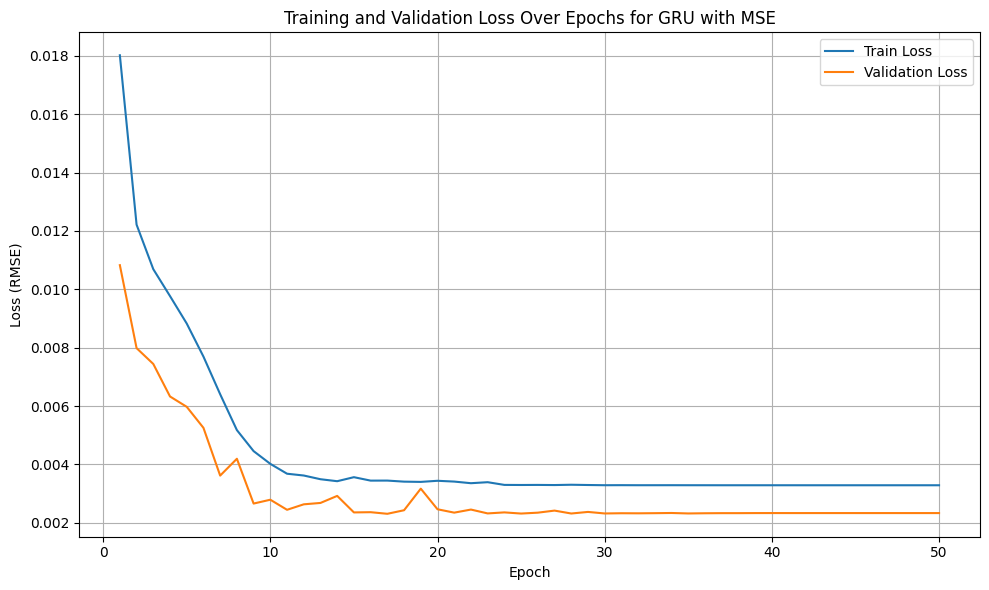

In [32]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.title(f"Training and Validation Loss Over Epochs for {NN_TYPE} with {LOSS_FUNC}")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"{RESULTS_PATH}/trainval_plots/trainval_{PLOT_FILENAME}")
plt.show()


## Test and Save Results
Results saved in ``src/results/metrics/results_MLP_no2_MSE_allyears.csv``

In [29]:
# best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 59.211965
Test RMSE Loss: 6.446422
Test SMAPE Loss: 26.829232%
Total Inference Time: 0.32 seconds


In [33]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_MSE_allyears.csv in Results/metrics folder


## Plot Model predictions vs True values
Plot saved ``src/results/plots/plot_MLP_no2_MSE_allyears.png``

In [ ]:
import torch
import matplotlib.pyplot as plt

# Dynamically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is on the right device and in eval mode
best_model_baseline.to(device)
best_model_baseline.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch
        x_test = x_test.to(device)
        y_true = y_true.to(device)

        # Get predictions
        y_pred = best_model_baseline(x_test)

        # Store results (move to CPU for plotting)
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to numpy arrays
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()

# Save and show plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
